# This notebook should run after Empirical Bayes Analysis

In [2]:
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from copy import deepcopy
import pandas as pd
from matplotlib import ticker as mticker
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import sys
sys.path.append('../src/')
import utils.utils as utils
import utils.process_utils as process_utils
import utils.dataloader_utils as dataloader_utils
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Evaluation 1: Evaluating AIC and BIC (ego)

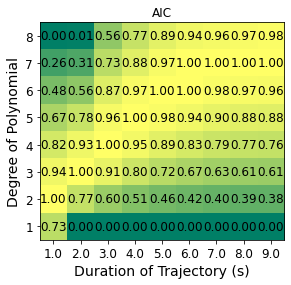

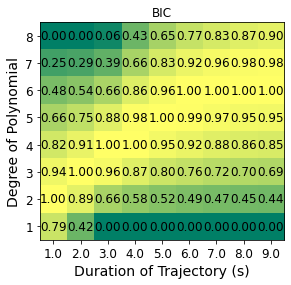

In [4]:
# Visualise AIC, BIC
num_of_points_list = [11, 21, 31, 41, 51, 61, 71, 81, 91]
degrees = [1, 2, 3, 4, 5, 6, 7, 8]
AIC_matrix = np.zeros((8, len(num_of_points_list)))
BIC_matrix = np.zeros((8, len(num_of_points_list)))
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
cmap = mpl.cm.summer
for idx, num_of_points in enumerate(num_of_points_list):
    folder_dir = 'logs/gradient_tape/ego/ego_xy' + str(num_of_points)
    file_name = 'result_summary'
    with open(folder_dir + '/' + file_name + '.json', "r") as read_file:
        result = json.load(read_file)
    AIC_score = np.array(result['aic_scores'])

    AIC_score = -AIC_score # reverse the score, so that the higher the better
    AIC_score_norm = (AIC_score - np.amin(AIC_score))/(np.amax(AIC_score) - np.amin(AIC_score))
    AIC_matrix[:, idx] = AIC_score_norm[::-1]
    
    BIC_score = np.array(result['bic_scores'])

    BIC_score = -BIC_score # reverse the score, so that the higher the better
    BIC_score_norm = (BIC_score - np.amin(BIC_score))/(np.amax(BIC_score) - np.amin(BIC_score))
    BIC_matrix[:, idx] = BIC_score_norm[::-1]


ax.imshow(AIC_matrix, cmap = cmap)
for (i, j), z in np.ndenumerate(AIC_matrix):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

ax.set_xticks(np.arange(0, AIC_matrix.shape[1], 1));
ax.set_yticks(np.arange(0, AIC_matrix.shape[0], 1));
ax.set_xticklabels((np.array(num_of_points_list)-1) / 10);
ax.set_yticklabels(degrees[::-1]);


ax2.imshow(BIC_matrix, cmap = cmap)
for (i, j), z in np.ndenumerate(BIC_matrix):
    ax2.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

ax2.set_xticks(np.arange(0, BIC_matrix.shape[1], 1));
ax2.set_yticks(np.arange(0, BIC_matrix.shape[0], 1));
ax2.set_xticklabels((np.array(num_of_points_list)-1) / 10);
ax2.set_yticklabels(degrees[::-1]);

#ax.set_title('Normalized avg. AIC (higher value is better)')
ax.set_title('AIC')
ax.set_ylabel('Degree of Polynomial')
ax.set_xlabel('Duration of Trajectory (s)')

fig.show()
fig.savefig('imgs/Waymo Normalized AIC related to the Duration of Trajectory.jpg', dpi = 300)

#ax2.set_title('Normalized avg. BIC (higher value is better)')
ax2.set_title('BIC')
ax2.set_ylabel('Degree of Polynomial')
ax2.set_xlabel('Duration of Trajectory (s)')

fig2.show()
fig2.savefig('imgs/Waymo Normalized BIC related to the Duration of Trajectory.jpg', dpi = 300)

## Evaluation 2: Analyse Fit Error (ego)

### Load Data

In [4]:
BATCH_SIZE = 1024
num_points_in_one_traj = 11

In [ ]:
# Load results
prior_folder_dir = 'logs/gradient_tape/ego/ego_xy' + str(num_points_in_one_traj) + '_new'
file_name = 'result_summary'

# Load prior parameters
with open(prior_folder_dir + '/' + file_name + '.json', "r") as read_file:
    result = json.load(read_file)
    
with open("data/ego/ego_trajs_" + str(num_points_in_one_traj) + "_json/ego_trajs_outlier_indicies.json", "r") as read_file:
    idx_invalid = set(json.load(read_file))
    

list_dataset = dataloader_utils.generate_file_list_dataset('data/ego/ego_trajs_json/', idx_invalid)
start_idx_dataset = dataloader_utils.generate_start_indicies_dataset("data/ego/ego_trajs_" + str(num_points_in_one_traj) + "_json/ego_trajs_start_point_indicies.json", idx_invalid)

combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = dataloader_utils.DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj, traj_type = 'ego_traj', with_heading=True)
dataProcessor.load_process()

print(dataProcessor.loaded_dataset.__len__())     

In [ ]:
with open("data/ego/ego_trajs_" + str(num_points_in_one_traj) + "_json/ego_trajs_filtered_CA.json", "r") as read_file:
    ego_smoothed_traj = np.array(json.load(read_file))[:, :, [0,3]] # [x,y]

smoothed_traj_dataset = tf.data.Dataset.from_tensor_slices(process_utils.get_smoothed_trajs_wo_outlier(ego_smoothed_traj, idx_invalid))
smoothed_traj_dataset = smoothed_traj_dataset.batch(BATCH_SIZE)
print(smoothed_traj_dataset.__len__())  

### Calculate fit error

In [ ]:
degrees = result['degree']

errors_gt_poly_lon = np.zeros((len(degrees), start_idx_dataset.__len__(),  num_points_in_one_traj))
errors_gt_poly_lat = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))

errors_kf_poly_lon = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))
errors_kf_poly_lat = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))

errors_gt_kf_lon = np.zeros((start_idx_dataset.__len__(), num_points_in_one_traj))
errors_gt_kf_lat = np.zeros((start_idx_dataset.__len__(), num_points_in_one_traj))

for idx_deg, deg in enumerate(tqdm(degrees)):
    current_batch_idx = 0
    print('Processing deg: ', deg)
    
    for (t_samples, mess_traj_samples, heading_samples), ks_traj_samples in zip(dataProcessor.loaded_dataset, smoothed_traj_dataset):
        next_batch_idx = current_batch_idx + mess_traj_samples.shape[0]
        t_samples = t_samples.numpy()
        mess_traj_samples = mess_traj_samples.numpy()
        heading_samples = heading_samples.numpy()
        ks_traj_samples = ks_traj_samples.numpy()
        
        ks_traj_samples =  np.concatenate((ks_traj_samples[:, :, 0], ks_traj_samples[:, :, 1]), axis = 1)
        

        heading_norm_samples = heading_samples[:, :, [1,0]] 
        heading_norm_samples[:, :, 0] = -heading_norm_samples[:, :, 0]
        
        
        phi_t_batch = utils.expand(t_samples, bf=utils.polynomial_basis_function, bf_args=range(1, deg+1)).transpose((1, 0, 2))
        phi_t_kron = np.kron(np.eye(2), phi_t_batch[:, :, 1:])

        A = np.array(result['A_list'][idx_deg])
        B_by_diag = np.eye(num_points_in_one_traj) * result['B_list'][idx_deg]['B_by_diag']
        by_eye = np.array([[0,1],[1,0]])
        B_diag = np.eye(2*num_points_in_one_traj) * result['B_list'][idx_deg]['B_diag']
        B = B_diag  + np.kron(by_eye, B_by_diag)
        

        
        phi_T_sigma_o = np.transpose(np.linalg.solve(B, phi_t_kron), (0,2,1))
        sigma_post_inv = np.linalg.inv(A) + phi_T_sigma_o @ phi_t_kron
        mu_N = np.linalg.solve(sigma_post_inv, phi_T_sigma_o) @ mess_traj_samples[:, :, None]
        pred = (phi_t_kron @ mu_N )[:, :, 0]
        
        
        error_gt_poly_x = mess_traj_samples[:, :num_points_in_one_traj] - pred[:, :num_points_in_one_traj]
        error_gt_poly_y = mess_traj_samples[:, num_points_in_one_traj:] - pred[:, num_points_in_one_traj:]
        error_gt_poly_lon, error_gt_poly_lat, _ = utils.project_error(error_gt_poly_x, error_gt_poly_y, heading_samples, heading_norm_samples, return_abs = True)
        errors_gt_poly_lon[idx_deg, current_batch_idx: next_batch_idx] = error_gt_poly_lon
        errors_gt_poly_lat[idx_deg, current_batch_idx: next_batch_idx] = error_gt_poly_lat

        error_kf_poly_x = ks_traj_samples[:, :num_points_in_one_traj] - pred[:, :num_points_in_one_traj]
        error_kf_poly_y = ks_traj_samples[:, num_points_in_one_traj:] - pred[:, num_points_in_one_traj:]
        error_kf_poly_lon, error_kf_poly_lat, _ = utils.project_error(error_kf_poly_x, error_kf_poly_y, heading_samples, heading_norm_samples, return_abs = True)
        errors_kf_poly_lon[idx_deg, current_batch_idx: next_batch_idx] = error_kf_poly_lon
        errors_kf_poly_lat[idx_deg, current_batch_idx: next_batch_idx] = error_kf_poly_lat
        
        
        error_x_gt_kf = mess_traj_samples[:, :num_points_in_one_traj] - ks_traj_samples[:, :num_points_in_one_traj]
        error_y_gt_kf = mess_traj_samples[:, num_points_in_one_traj:] - ks_traj_samples[:, num_points_in_one_traj:]
        error_gt_kf_lon, error_gt_kf_lat, _ = utils.project_error(error_x_gt_kf, error_y_gt_kf, heading_samples, heading_norm_samples, return_abs = True)
        errors_gt_kf_lon[current_batch_idx: next_batch_idx] = error_gt_kf_lon
        errors_gt_kf_lat[current_batch_idx: next_batch_idx] = error_gt_kf_lat
        
        current_batch_idx = next_batch_idx

print('finished')      

In [16]:
summary_lon = {'attributes': ['mean', 'median', '99.9% percentile', 'max', 'min']}

summary_temp = []
print('Error in longitudinal')
print('Messurement vs Polynomial')    
for idx, deg in enumerate(degrees):
    error = errors_gt_poly_lon[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lon['gt_poly'] = summary_temp
    
    
summary_temp = []
print('\n')
print('Kalman Smoother vs Polynomial')
for idx, deg in enumerate(degrees):
    error = errors_kf_poly_lon[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lon['kf_poly'] = summary_temp
    
summary_temp = []
print('\n')
print('Kalman Smoother vs Messurement')
print('Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(np.mean(errors_gt_kf_lon), np.median(errors_gt_kf_lon), np.percentile(errors_gt_kf_lon.reshape((-1)), [99.9]), np.max(errors_gt_kf_lon), np.min(errors_gt_kf_lon)))
summary_lon['gt_kf'] = [np.mean(errors_gt_kf_lon), np.median(errors_gt_kf_lon), np.percentile(errors_gt_kf_lon.reshape((-1)), 99.9), np.max(errors_gt_kf_lon), np.min(errors_gt_kf_lon)]

Error in longitudinal
Mess vs Poly
Deg: 1, Mean: 2.47807, Median: 1.58476, 99.9% Percentil: 16.38415, Max: 38.02576; Min: 0.00000
Deg: 2, Mean: 0.49168, Median: 0.33509, 99.9% Percentil: 3.39278, Max: 8.26967; Min: 0.00000
Deg: 3, Mean: 0.17387, Median: 0.10979, 99.9% Percentil: 1.29426, Max: 3.46669; Min: 0.00000
Deg: 4, Mean: 0.08162, Median: 0.05057, 99.9% Percentil: 0.63946, Max: 1.86550; Min: 0.00000
Deg: 5, Mean: 0.04488, Median: 0.02749, 99.9% Percentil: 0.36354, Max: 1.59930; Min: 0.00000
Deg: 6, Mean: 0.02724, Median: 0.01667, 99.9% Percentil: 0.22489, Max: 1.53767; Min: 0.00000
Deg: 7, Mean: 0.01834, Median: 0.01128, 99.9% Percentil: 0.15375, Max: 1.49674; Min: 0.00000
Deg: 8, Mean: 0.01761, Median: 0.01076, 99.9% Percentil: 0.15067, Max: 1.52438; Min: 0.00000


KF vs Poly
Deg: 1, Mean: 2.47803, Median: 1.58475, 99.9% Percentil: 16.38464, Max: 38.03150; Min: 0.00000
Deg: 2, Mean: 0.49148, Median: 0.33493, 99.9% Percentil: 3.39210, Max: 8.27075; Min: 0.00000
Deg: 3, Mean: 0.17

In [17]:
summary_lat = {'attributes': ['mean', 'median', '99.9% percentile', 'max', 'min']}

summary_temp = []
print('Error in lateral')
print('Messurement vs Polynomial')    
for idx, deg in enumerate(degrees):
    error = errors_gt_poly_lat[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lat['gt_poly'] = summary_temp

summary_temp = []
print('\n')
print('Kalman Smoother vs Polynomial')
for idx, deg in enumerate(degrees):
    error = errors_kf_poly_lat[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lat['kf_poly'] = summary_temp
    
summary_temp = []
print('\n')
print('Kalman Smoother vs Messurement')
print('Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(np.mean(errors_gt_kf_lat), np.median(errors_gt_kf_lat), np.percentile(errors_gt_kf_lat.reshape((-1)), [99.9]), np.max(errors_gt_kf_lat), np.min(errors_gt_kf_lat)))
summary_lat['gt_kf'] = [np.mean(errors_gt_kf_lat), np.median(errors_gt_kf_lat), np.percentile(errors_gt_kf_lat.reshape((-1)), 99.9), np.max(errors_gt_kf_lat), np.min(errors_gt_kf_lat)]

Error in lateral
Mess vs Poly
Deg: 1, Mean: 0.65142, Median: 0.06541, 99.9% Percentil: 12.22777, Max: 25.05657; Min: 0.00000
Deg: 2, Mean: 0.18720, Median: 0.02856, 99.9% Percentil: 3.10892, Max: 11.71043; Min: 0.00000
Deg: 3, Mean: 0.07476, Median: 0.01374, 99.9% Percentil: 1.24948, Max: 3.46855; Min: 0.00000
Deg: 4, Mean: 0.03524, Median: 0.00733, 99.9% Percentil: 0.58432, Max: 1.72069; Min: 0.00000
Deg: 5, Mean: 0.01837, Median: 0.00438, 99.9% Percentil: 0.30575, Max: 1.06691; Min: 0.00000
Deg: 6, Mean: 0.01043, Median: 0.00285, 99.9% Percentil: 0.17247, Max: 0.68356; Min: 0.00000
Deg: 7, Mean: 0.00663, Median: 0.00206, 99.9% Percentil: 0.10362, Max: 0.44797; Min: 0.00000
Deg: 8, Mean: 0.00631, Median: 0.00198, 99.9% Percentil: 0.10031, Max: 0.39033; Min: 0.00000


KF vs Poly
Deg: 1, Mean: 0.65139, Median: 0.06538, 99.9% Percentil: 12.22768, Max: 25.05199; Min: 0.00000
Deg: 2, Mean: 0.18712, Median: 0.02850, 99.9% Percentil: 3.10829, Max: 11.70848; Min: 0.00000
Deg: 3, Mean: 0.07462

### Save results

In [18]:
PATH = 'results/ego/ego_pos_error/' + str(num_points_in_one_traj)
if not os.path.exists(PATH):
    os.makedirs(PATH)
    
with open(PATH + '/gt_poly_lon' + '.json', "w") as write_file:
    json.dump(errors_gt_poly_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/gt_poly_lat' + '.json', "w") as write_file:
    json.dump(errors_gt_poly_lat, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/kf_poly_lon' + '.json', "w") as write_file:
    json.dump(errors_kf_poly_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/kf_poly_lat' + '.json', "w") as write_file:
    json.dump(errors_kf_poly_lat, write_file, cls=utils.NumpyEncoder)
    
with open(PATH+ '/gt_kf_lon' + '.json', "w") as write_file:
    json.dump(errors_gt_kf_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/gt_kf_lat' + '.json', "w") as write_file:
    json.dump(errors_gt_kf_lat, write_file, cls=utils.NumpyEncoder)

In [19]:
with open(PATH + '/summary_lon' + '.json', "w") as write_file:
    json.dump(summary_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/summary_lat' + '.json', "w") as write_file:
    json.dump(summary_lat, write_file, cls=utils.NumpyEncoder)

## Evaluation 3: Evaluate AIC and BIC (agt)

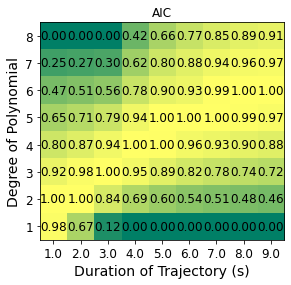

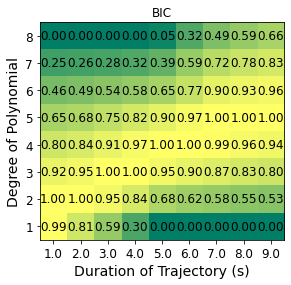

In [6]:
# Visualise AIC, BIC
object_type = 'cyclist'
num_of_points_list = [11, 21, 31, 41, 51, 61, 71, 81, 91]
degrees = [1, 2, 3, 4, 5, 6, 7, 8]
AIC_matrix = np.zeros((8, len(num_of_points_list)))
BIC_matrix = np.zeros((8, len(num_of_points_list)))
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
cmap = mpl.cm.summer
for idx, num_of_points in enumerate(num_of_points_list):
    folder_dir = 'logs/gradient_tape/' + object_type + '/agt_xy_polar_plus_const_' + str(num_of_points)
    file_name = 'result_summary'
    with open(folder_dir + '/' + file_name + '.json', "r") as read_file:
        result = json.load(read_file)
    AIC_score = np.array(result['aic_scores'])

    AIC_score = -AIC_score # reverse the score, so that the higher the better
    AIC_score_norm = (AIC_score - np.amin(AIC_score))/(np.amax(AIC_score) - np.amin(AIC_score))
    AIC_matrix[:, idx] = AIC_score_norm[::-1]
    
    BIC_score = np.array(result['bic_scores'])

    BIC_score = -BIC_score # reverse the score, so that the higher the better
    BIC_score_norm = (BIC_score - np.amin(BIC_score))/(np.amax(BIC_score) - np.amin(BIC_score))
    BIC_matrix[:, idx] = BIC_score_norm[::-1]


ax.imshow(AIC_matrix, cmap = cmap)
for (i, j), z in np.ndenumerate(AIC_matrix):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

ax.set_xticks(np.arange(0, AIC_matrix.shape[1], 1));
ax.set_yticks(np.arange(0, AIC_matrix.shape[0], 1));
ax.set_xticklabels((np.array(num_of_points_list)-1) / 10);
ax.set_yticklabels(degrees[::-1]);


ax2.imshow(BIC_matrix, cmap = cmap)
for (i, j), z in np.ndenumerate(BIC_matrix):
    ax2.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

ax2.set_xticks(np.arange(0, BIC_matrix.shape[1], 1));
ax2.set_yticks(np.arange(0, BIC_matrix.shape[0], 1));
ax2.set_xticklabels((np.array(num_of_points_list)-1) / 10);
ax2.set_yticklabels(degrees[::-1]);

#ax.set_title('Normalized avg. AIC (higher value is better)')
ax.set_title('AIC')
ax.set_ylabel('Degree of Polynomial')
ax.set_xlabel('Duration of Trajectory (s)')

fig.show()
fig.savefig('imgs/Argoverse 2 Normalized AIC related to the Duration of Trajectory (agt ' + object_type + ').pdf', dpi = 300)

#ax2.set_title('Normalized avg. BIC (higher value is better)')
ax2.set_title('BIC')
ax2.set_ylabel('Degree of Polynomial')
ax2.set_xlabel('Duration of Trajectory (s)')

fig2.show()
fig2.savefig('imgs/Argoverse 2 Normalized BIC related to the Duration of Trajectory (agt ' + object_type + ').pdf', dpi = 300)

## Evaluation 4: Analyse Fit Error (agt)

### Load Data

In [16]:
BATCH_SIZE = 1024

object_type = 'cyclist'
num_points_in_one_traj = 11

In [ ]:
# Load results
prior_folder_dir = 'logs/gradient_tape/' + object_type + '/agt_xy_polar_plus_const_' + str(num_points_in_one_traj)
file_name = 'result_summary'

# Load prior parameters
with open(prior_folder_dir + '/' + file_name + '.json', "r") as read_file:
    result = json.load(read_file)

if object_type == 'vehicle':
    with open("data/"+ object_type + "/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_select_non_outlier_indicies.json", "r") as read_file:
        idx_trajs_select = json.load(read_file)

    list_dataset = dataloader_utils.generate_selected_file_list_dataset('data'+ object_type + '/agt_trajs_json/', idx_trajs_select)
    start_idx_dataset = dataloader_utils.generate_selected_start_indicies_dataset("data/"+ object_type + "agt_trajs_" + str(num_points_in_one_traj) + "_json_new/agt_trajs_start_point_indicies.json")
else:
    with open("data/"+ object_type + "/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_outlier_indicies.json", "r") as read_file:
        idx_outlier = json.load(read_file)
        
    list_dataset = dataloader_utils.generate_file_list_dataset('data/'+ object_type + '/agt_trajs_json/', idx_outlier)
    start_idx_dataset = dataloader_utils.generate_start_indicies_dataset("data/"+ object_type + "/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_start_point_indicies.json", idx_outlier)
        
combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = dataloader_utils.DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj, traj_type='agt_traj', with_heading=True)
dataProcessor.load_process(shuffle = False)

print(dataProcessor.loaded_dataset.__len__())

In [ ]:
with open("data/" + object_type + "/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_filtered_CA.json", "r") as read_file:
    agt_smoothed_traj = np.array(json.load(read_file))[:, :, [0,3]] 

if object_type == 'vehicle':
    smoothed_traj_dataset = tf.data.Dataset.from_tensor_slices(agt_smoothed_traj)
else:
    smoothed_traj_dataset = tf.data.Dataset.from_tensor_slices(process_utils.get_smoothed_trajs_wo_outlier((agt_smoothed_traj, idx_outlier))
                                                               
smoothed_traj_dataset = smoothed_traj_dataset.batch(BATCH_SIZE)
print(smoothed_traj_dataset.__len__())  

### Calculate fit error

In [27]:
degrees = result['degree']

errors_gt_poly_lon = np.zeros((len(degrees), start_idx_dataset.__len__(),  num_points_in_one_traj))
errors_gt_poly_lat = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))

errors_kf_poly_lon = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))
errors_kf_poly_lat = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))

errors_gt_kf_lon = np.zeros((start_idx_dataset.__len__(), num_points_in_one_traj))
errors_gt_kf_lat = np.zeros((start_idx_dataset.__len__(), num_points_in_one_traj))

poly_fit = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj* 2))

ob_error = np.zeros((start_idx_dataset.__len__(), num_points_in_one_traj))

for idx_deg, deg in enumerate(tqdm(degrees)):
    current_batch_idx = 0
    print('Processing deg: ', deg)
    
    for (t_samples, mess_traj_samples, heading_samples, d_norm_samples, theta_samples, R_samples), ks_traj_samples in zip(dataProcessor.loaded_dataset, smoothed_traj_dataset):
        next_batch_idx = current_batch_idx + mess_traj_samples.shape[0]
        t_samples = t_samples.numpy()
        mess_traj_samples = mess_traj_samples.numpy()
        heading_samples = heading_samples.numpy()
        d_norm_samples = d_norm_samples.numpy()
        theta_samples = theta_samples.numpy()
        R_samples = R_samples.numpy()
        R_samples = np.transpose(R_samples, (0, 2, 3, 1))
        ks_traj_samples = ks_traj_samples.numpy()
        ks_traj_samples =  np.concatenate((ks_traj_samples[:, :, 0], ks_traj_samples[:, :, 1]), axis = 1)
        
        heading_norm_samples = heading_samples[:, :, [1,0]] 
        heading_norm_samples[:, :, 0] = -heading_norm_samples[:, :, 0]
        
        phi_t_batch = utils.expand(t_samples, bf=utils.polynomial_basis_function, bf_args=range(1, deg+1)).transpose((1, 0, 2))
        phi_t_kron = np.kron(np.eye(2), phi_t_batch[:, :, 1:])
        
        phi_d = utils.expand(d_norm_samples, bf=utils.polynomial_basis_function, bf_args=range(1, 2+1)).transpose((1, 0, 2))

        A = np.array(result['A_list'][deg-1])
        b_d = np.squeeze(np.array(result['B_list'][deg-1]['B_d']))
        b_theta = np.squeeze(np.array(result['B_list'][deg-1]['B_theta']))
        b_const = np.squeeze(np.array(result['B_list'][deg-1]['B_const']))

        R = np.block([[tf.linalg.diag(R_samples[:, 0, 0]), tf.linalg.diag(R_samples[:, 0, 1])],
                      [tf.linalg.diag(R_samples[:, 1, 0]), tf.linalg.diag(R_samples[:, 1, 1])]])
        
        var_d = np.squeeze(phi_d @ b_d)
        var_theta =  b_theta
        theta_cos = tf.math.cos(theta_samples)
        theta_sin = tf.math.sin(theta_samples)
        d_pow =  tf.math.pow(d_norm_samples, 2)
        var_lon_lon = var_d * tf.math.pow(theta_cos, 2) + var_theta *  d_pow * tf.math.pow(theta_sin, 2)
        var_lat_lat = var_d * tf.math.pow(theta_sin, 2) + var_theta *  d_pow * tf.math.pow(theta_cos, 2)
        var_lon_lat = var_d * theta_sin * theta_cos - var_theta *  d_pow * theta_sin * theta_cos 
        
        by_eye = np.array([[0,1],[1,0]])
        b_lon_lat_by_diag = np.kron(by_eye, tf.linalg.diag(var_lon_lat))
        
        b_lon_lat_diag = tf.linalg.diag(tf.concat([var_lon_lon + b_const, var_lat_lat + b_const], axis = 1)).numpy()
        b_lon_lat = b_lon_lat_diag + b_lon_lat_by_diag
        
        
        B   = R @ b_lon_lat @ np.transpose(R, (0, 2, 1))

        
        phi_T_sigma_o = np.transpose(np.linalg.solve(B, phi_t_kron), (0,2,1))
        sigma_post_inv = np.linalg.inv(A) + phi_T_sigma_o @ phi_t_kron
        mu_N = np.linalg.solve(sigma_post_inv, phi_T_sigma_o) @ mess_traj_samples[:, :, None]
    
        pred = (phi_t_kron @ mu_N )[:, :, 0]
        
        error_gt_poly_x = mess_traj_samples[:, :num_points_in_one_traj] - pred[:, :num_points_in_one_traj]
        error_gt_poly_y = mess_traj_samples[:, num_points_in_one_traj:] - pred[:, num_points_in_one_traj:]
        error_gt_poly_lon, error_gt_poly_lat, _ = utils.project_error(error_gt_poly_x, error_gt_poly_y, heading_samples, heading_norm_samples, return_abs = True)
        errors_gt_poly_lon[idx_deg, current_batch_idx: next_batch_idx] = error_gt_poly_lon
        errors_gt_poly_lat[idx_deg, current_batch_idx: next_batch_idx] = error_gt_poly_lat

        error_kf_poly_x = ks_traj_samples[:, :num_points_in_one_traj] - pred[:, :num_points_in_one_traj]
        error_kf_poly_y = ks_traj_samples[:, num_points_in_one_traj:] - pred[:, num_points_in_one_traj:]
        error_kf_poly_lon, error_kf_poly_lat, _ = utils.project_error(error_kf_poly_x, error_kf_poly_y, heading_samples, heading_norm_samples, return_abs = True)
        errors_kf_poly_lon[idx_deg, current_batch_idx: next_batch_idx] = error_kf_poly_lon
        errors_kf_poly_lat[idx_deg, current_batch_idx: next_batch_idx] = error_kf_poly_lat
        
        
        error_x_gt_kf = mess_traj_samples[:, :num_points_in_one_traj] - ks_traj_samples[:, :num_points_in_one_traj]
        error_y_gt_kf = mess_traj_samples[:, num_points_in_one_traj:] - ks_traj_samples[:, num_points_in_one_traj:]
        error_gt_kf_lon, error_gt_kf_lat, _ = utils.project_error(error_x_gt_kf, error_y_gt_kf, heading_samples, heading_norm_samples, return_abs = True)
        errors_gt_kf_lon[current_batch_idx: next_batch_idx] = error_gt_kf_lon
        errors_gt_kf_lat[current_batch_idx: next_batch_idx] = error_gt_kf_lat
        

        current_batch_idx = next_batch_idx

print('finished')      

  0%|          | 0/8 [00:00<?, ?it/s]

Processing deg:  1


 12%|█▎        | 1/8 [08:24<58:51, 504.49s/it]

Processing deg:  2


 25%|██▌       | 2/8 [13:46<39:43, 397.28s/it]

Processing deg:  3


 38%|███▊      | 3/8 [19:09<30:15, 363.05s/it]

Processing deg:  4


 50%|█████     | 4/8 [24:31<23:08, 347.05s/it]

Processing deg:  5


 62%|██████▎   | 5/8 [29:53<16:54, 338.10s/it]

Processing deg:  6


 75%|███████▌  | 6/8 [35:16<11:05, 332.74s/it]

Processing deg:  7


 88%|████████▊ | 7/8 [40:38<05:29, 329.34s/it]

Processing deg:  8


100%|██████████| 8/8 [47:00<00:00, 352.59s/it]

finished


In [ ]:
summary_lon = {'attributes': ['mean', 'median', '99.9% percentile', 'max', 'min']}

summary_temp = []
print('Error in longitudinal')
print('Messurement vs Polynomial')    
for idx, deg in enumerate(degrees):
    error = errors_gt_poly_lon[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lon['gt_poly'] = summary_temp
    
    
summary_temp = []
print('\n')
print('Kalman Smoother vs Polynomial')
for idx, deg in enumerate(degrees):
    error = errors_kf_poly_lon[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lon['kf_poly'] = summary_temp
    
summary_temp = []
print('\n')
print('Kalman Smoother vs Messurement')
print('Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(np.mean(errors_gt_kf_lon), np.median(errors_gt_kf_lon), np.percentile(errors_gt_kf_lon.reshape((-1)), [99.9]), np.max(errors_gt_kf_lon), np.min(errors_gt_kf_lon)))
summary_lon['gt_kf'] = [np.mean(errors_gt_kf_lon), np.median(errors_gt_kf_lon), np.percentile(errors_gt_kf_lon.reshape((-1)), 99.9), np.max(errors_gt_kf_lon), np.min(errors_gt_kf_lon)]

Error in longitudinal
Mess vs Poly
Deg: 1, Mean: 0.32893, Median: 0.17955, 99.9% Percentil: 3.06031, Max: 7.88650; Min: 0.00000
Deg: 2, Mean: 0.07110, Median: 0.04393, 99.9% Percentil: 0.65270, Max: 1.69551; Min: 0.00000
Deg: 3, Mean: 0.03816, Median: 0.02629, 99.9% Percentil: 0.30395, Max: 0.91049; Min: 0.00000
Deg: 4, Mean: 0.02903, Median: 0.02068, 99.9% Percentil: 0.21200, Max: 0.79817; Min: 0.00000
Deg: 5, Mean: 0.02493, Median: 0.01793, 99.9% Percentil: 0.17751, Max: 0.76396; Min: 0.00000
Deg: 6, Mean: 0.02443, Median: 0.01759, 99.9% Percentil: 0.17436, Max: 0.76222; Min: 0.00000
Deg: 7, Mean: 0.02273, Median: 0.01633, 99.9% Percentil: 0.16593, Max: 0.73523; Min: 0.00000
Deg: 8, Mean: 0.02260, Median: 0.01624, 99.9% Percentil: 0.16496, Max: 0.74018; Min: 0.00000


KF vs Poly
Deg: 1, Mean: 0.32696, Median: 0.17698, 99.9% Percentil: 3.06216, Max: 7.95890; Min: 0.00000
Deg: 2, Mean: 0.06467, Median: 0.03609, 99.9% Percentil: 0.64517, Max: 1.67050; Min: 0.00000
Deg: 3, Mean: 0.02756,

In [ ]:
summary_lat = {'attributes': ['mean', 'median', '99.9% percentile', 'max', 'min']}

summary_temp = []
print('Error in lateral')
print('Messurement vs Polynomial')    
for idx, deg in enumerate(degrees):
    error = errors_gt_poly_lat[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lat['gt_poly'] = summary_temp

summary_temp = []
print('\n')
print('Kalman Smoother vs Polynomial')
for idx, deg in enumerate(degrees):
    error = errors_kf_poly_lat[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lat['kf_poly'] = summary_temp
    
summary_temp = []
print('\n')
print('Kalman Smoother vs Messurement')
print('Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(np.mean(errors_gt_kf_lat), np.median(errors_gt_kf_lat), np.percentile(errors_gt_kf_lat.reshape((-1)), [99.9]), np.max(errors_gt_kf_lat), np.min(errors_gt_kf_lat)))
summary_lat['gt_kf'] = [np.mean(errors_gt_kf_lat), np.median(errors_gt_kf_lat), np.percentile(errors_gt_kf_lat.reshape((-1)), 99.9), np.max(errors_gt_kf_lat), np.min(errors_gt_kf_lat)]

Error in lateral
Mess vs Poly
Deg: 1, Mean: 0.26354, Median: 0.11539, 99.9% Percentil: 3.39574, Max: 7.67183; Min: 0.00000
Deg: 2, Mean: 0.08437, Median: 0.04771, 99.9% Percentil: 0.94254, Max: 2.43371; Min: 0.00000
Deg: 3, Mean: 0.03904, Median: 0.02544, 99.9% Percentil: 0.38992, Max: 1.13257; Min: 0.00000
Deg: 4, Mean: 0.02276, Median: 0.01618, 99.9% Percentil: 0.19657, Max: 0.55603; Min: 0.00000
Deg: 5, Mean: 0.01572, Median: 0.01176, 99.9% Percentil: 0.11640, Max: 0.31761; Min: 0.00000
Deg: 6, Mean: 0.01437, Median: 0.01086, 99.9% Percentil: 0.10146, Max: 0.31465; Min: 0.00000
Deg: 7, Mean: 0.01225, Median: 0.00934, 99.9% Percentil: 0.08293, Max: 0.31081; Min: 0.00000
Deg: 8, Mean: 0.01221, Median: 0.00932, 99.9% Percentil: 0.08249, Max: 0.31288; Min: 0.00000


KF vs Poly
Deg: 1, Mean: 0.26245, Median: 0.11408, 99.9% Percentil: 3.39007, Max: 7.70937; Min: 0.00000
Deg: 2, Mean: 0.08184, Median: 0.04493, 99.9% Percentil: 0.92818, Max: 2.44689; Min: 0.00000
Deg: 3, Mean: 0.03452, Medi

### Save results

In [ ]:
PATH = 'results/agt_pos_error_polar/' + object_type + '/' + str(num_points_in_one_traj) + '_track'
if not os.path.exists(PATH):
    os.makedirs(PATH)

with open(PATH + '/gt_poly_lon' + '.json', "w") as write_file:
    json.dump(errors_gt_poly_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/gt_poly_lat' + '.json', "w") as write_file:
    json.dump(errors_gt_poly_lat, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/kf_poly_lon' + '.json', "w") as write_file:
    json.dump(errors_kf_poly_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/kf_poly_lat' + '.json', "w") as write_file:
    json.dump(errors_kf_poly_lat, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/gt_kf_lon' + '.json', "w") as write_file:
    json.dump(errors_gt_kf_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/gt_kf_lat' + '.json', "w") as write_file:
    json.dump(errors_gt_kf_lat, write_file, cls=utils.NumpyEncoder)

In [31]:
with open(PATH + '/summary_lon' + '.json', "w") as write_file:
    json.dump(summary_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/summary_lat' + '.json', "w") as write_file:
    json.dump(summary_lat, write_file, cls=utils.NumpyEncoder)